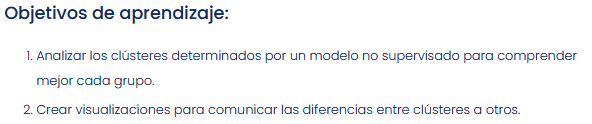

#**Introduccion**

Los algoritmos del agrupamiento no supervisado agrupan los puntos de datos juntos basandose en algunas medidas de semejanza. Sin embargo, en cuanto los grupos se hayan determinado, que significan? como le podemos explicar a nuestros accionistas que hace que los datos dentro de un cluster sean similares a otros datos del cluster y diferentes a otros datos en otros clusteres?

Esto toma tiempo en analizar cada cluster individualmente y en comparar cada cluster de los otros. Al hacer esto, podemos encontrar tendencias sobre las que informar.


#**Ejemplo: Segmentacion de paises**

En este ejemplo, una organizacion sin fines de lucro quiere dirigirse a paises para realizar obras y proyectos beneficos. Quieren que nos dirijamos a un grupo de paises que necesitan de estos servicios. Nos han pedido agrupar las naciones utilizando los datos que nos proporcionaron para identificar un grupo de paises en los que deberian centrarse. Tambien quisieran saber que tipos de problemas deberia abordar en estos paises.

#**Carga y limpieza de datos**

Cargaremos, escalaremos y agruparemos los datos como siempre, asegurandonos de elegir el numero optimo de los clusteres para obtener los paises mas parecidos.

Primero, examinaremos lo que el diccionario de datos proporciono para tener una idea de lo que tratan estos datos. Siempre es importante comprender nuestros datos antes de hacer un analisis.

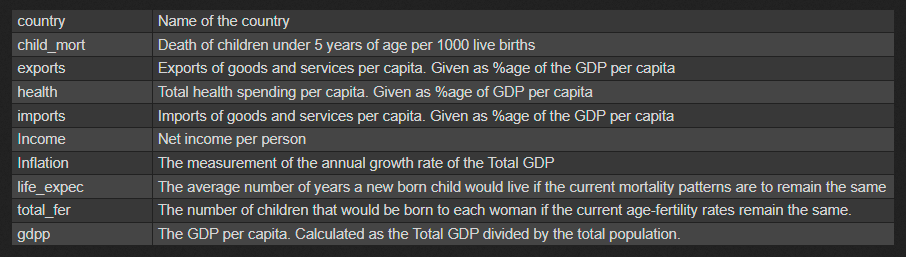


vemos que nuestros datos incluyen informacion relacionada con la economia y salud.

Ahora importemos nuestros paquetes y datos para ver como lce nuestro dataframe. Puesto que cada fila representa un pais diferente, le podemos dar instrucciones a pandas para que establezca esa columna como indice.

In [ ]:
from google.colab import drive
drive.mount ("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
df = pd.read_csv("/content/drive/MyDrive/Data CodingDojo/Country-data - Country-data.csv", index_col="country")
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
print('Number of Duplicated Rows', df.duplicated().sum())
print('\n')
df.info()

Number of Duplicated Rows 0


<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


In [ ]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


#**Escalamiento y modelado**

El escalamiento siempre es necesario antes de utilizar un modelo basado en distancia,y la agrupacion se basa en distancia. Por lo tanto, escalaremos nuestros datos antes de modelarlo.

In [ ]:
# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
X_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


Ahora encajemos algunos modos de k-medias con diferentes números de clústeres para ver cuántos clústeres son óptimos.

Es importante establecer un estado aleatorio para los modelos k-medias para la reproducibilidad. 

Tienen puntos de partida aleatorios para sus centroides iniciales, y nosotros obtendremos diferentes resultados con diferentes ejecuciones si no establecemos un estado aleatorio.

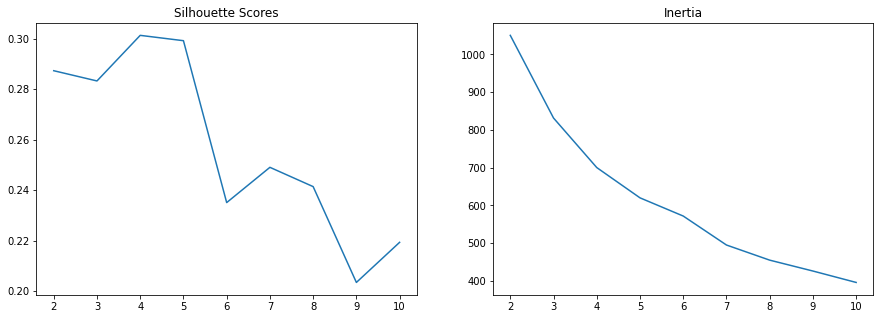

In [ ]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_scaled)
  sils.append(silhouette_score(X_scaled, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

Podemos observar que agrupar los datos en 4 grupos nos da la mejor puntuación de silueta y podemos detectar un codo en el trazado de inercia en 4.  Si bien el trazado de inercia no tiene un codo muy pronunciado en ningún número, la puntuación de silueta parece favorecer los grupos 4 o 5.  Escogeremos el 4.  

Ajustemos un nuevo modelo con 4 clústeres y agreguemos esos clústeres a una nueva columna en nuestro dataframe original (sin escala).

In [ ]:
# Refit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


#**Analizar los clústeres**

Ahora que hemos agrupado los datos, podemos analizar los clústeres.  Queremos obtener algunas estadísticas resumidas sobre cada clúster.  ¿Qué estadística queremos?  

Los valores medios de cada característica serán los más útiles para entender los clústeres en su conjunto.  Recuperar los valores máximos o mínimos puede ser interesante en algunos casos, pero los valores medios nos dan la idea del clúster en su conjunto.

Agruparemos los datos por clúster y agregaremos los grupos por los valores medios de cada característica.

In [ ]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,21.389655,41.290678,6.235862,48.038689,12968.620690,7.413460,72.935632,2.286552,6919.103448
1,1,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979
2,2,4.953333,45.826667,9.168667,39.736667,45250.000000,2.742200,80.376667,1.795333,43333.333333
3,3,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667


La tabla anterior nos da mucha información sobre cada clúster, pero visualizar los datos nos puede ayudar a crear una intuición sobre los clústeres.

#Visualizar los clústeres

Como científicos de datos, lidiamos mucho con los números, pero trazar valores es ideal para la comparación e importante para las presentaciones.  Ahora que tenemos nuestros datos agrupados y los valores medios para cada característica calculados, Pandas y Matplotlib hacen que sea bastante sencillo trazar nuestros datos.

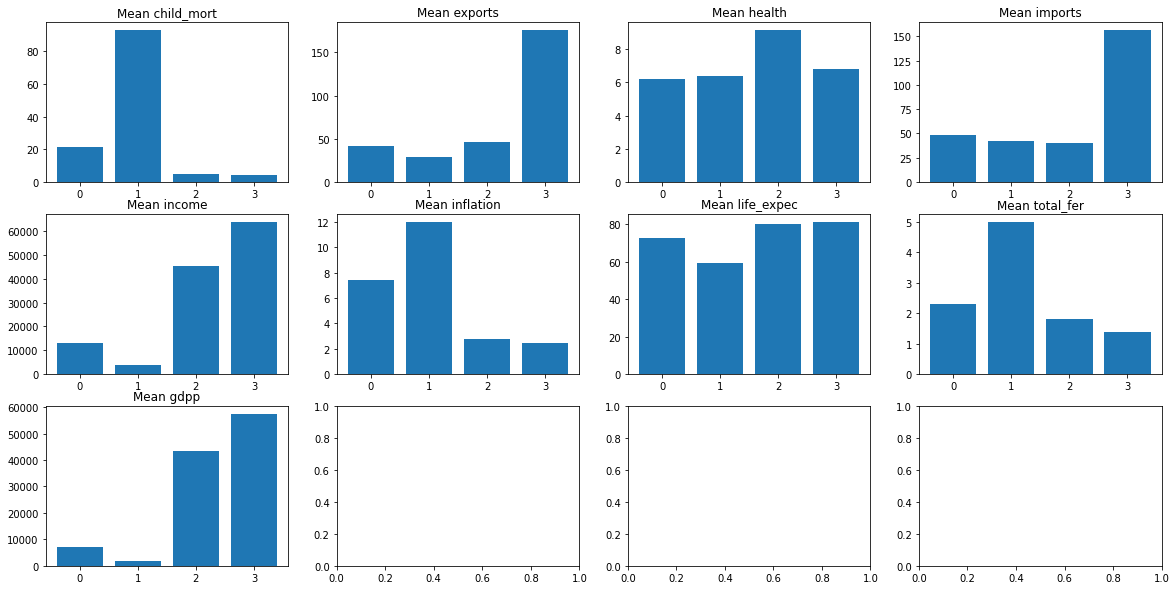

In [ ]:
# Visualize means 
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

Clúster 0:

El clúster 0 tiene una alta tasa de mortalidad infantil, pero también un ingreso promedio considerablemente mayor que la del clúster 1. La esperanza de vida está más cerca a los clústeres 2 y 3, pero sigue siendo muy baja.  Los clústeres 0 y 1 son similares, pero las naciones en el clúster 0 parecen tender a estar un poco más desarrolladas y pueden tener cierta industrialización y recursos naturales para comerciar con otras naciones.  El clúster 0 tiene exportaciones similares al clúster 2, a pesar del bajo ingreso promedio y PIB por persona.  Además del clúster 1, estas naciones pueden ser buenos candidatos para actividades benéficas de las partes interesadas.  Sin embargo, parecen estar en una posición levemente mejor. 

Clúster 1:

 El clúster 1 tiene la tasa de mortalidad infantil más alta, con menos exportaciones, el ingreso promedio más bajo, la inflación más alta, la esperanza de vida más baja, la mayor tasa de fertilidad y el menor PIB por persona.  Si bien sus exportaciones son mucho más bajas que los otros clústeres, sus índices de importaciones son similares a los clústeres 0 y 2.  Esto puede significar que son dependientes de los bienes extranjeros, pero no producen muchos bienes para exportar.  Las poblaciones en estas naciones tienden a estar desesperadamente empobrecidas e insalubres.  Este clúster puede ser un buen candidato para los esfuerzos de nuestras partes interesadas.  

Clúster 2: 

Las naciones de clúster 2 tienen notablemente bajas importaciones y exportaciones que el clúster 3, pero son similares a los índices de mortalidad e inflación, ambas siendo bajas.  Si bien los individuos de estas naciones han disminuido de alguna forma sus ingresos más que el clúster y el PIB por persona es más baja, estos parecen estar más sanos.  Estas naciones parecen ser más autosuficientes, dependen menos del comercio exterior, pero tienen poblaciones generalmente sanas y confortables.  Estos no serían candidatos para las actividades benéficas. 

Clúster 3:

El clúster 3 tiene la tasa de mortalidad infantil más baja, el mayor número de exportaciones e importaciones, el ingreso promedio más alto, menos inflación, la esperanza de vida más alta, el menor índice de fertilidad y el mayor PIB por persona.  Por lo que sabemos del mundo, nos imaginaríamos que esto pertenece a las naciones industrializadas del primer mundo muy implicadas en el comercio internacional.  Estos no serían buenos candidatos para las actividades benéficas de las partes interesadas.

#Filtración de dataframe por un clúster

Ahora tenemos una selección de gráficos mostrando visualmente las comparaciones entre cada clúster para cada una de las características.  En nuestra presentación podemos elegir a algunos de ellos para destacarlos con el fin de argumentar que los países en el clúster 1 son aquellos en los que deben concentrarse nuestras partes interesadas.  Echemos un vistazo a cuáles son esos países.  Recuerden que establecimos los nombres de los países en el índice de nuestro dataframe, por lo que eso es lo que vamos a imprimir.

In [ ]:
df.loc[df['cluster']==1].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia',
       'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone',
       'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda',
       'Yemen', 'Zambia'],
      dtype='object', name='country')

In [ ]:
df[df["cluster"]==1].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia',
       'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone',
       'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda',
       'Yemen', 'Zambia'],
      dtype='object', name='country')

#Resumen

En esta clase aprendiste a cómo agrupar tus datos, agruparlos por clúster y luego realizar algunos análisis de cada clúster para la comparación.  Ahora puedes crear una tabla de valores medios para cada característica para cada clúster y crear rápidamente gráficos de barras para esos valores para compararlos visualmente.  También puedes filtrar tu dataframe para obtener las muestras individuales en un clúster.